### ex_13_2 RNN

根据名字识别他所在的国家

人名字符长短不一，最长的10个字符，所以处理成10维输入张量，都是英文字母刚好可以映射到ASCII上

Maclean ->  ['M', 'a', 'c', 'l', 'e', 'a', 'n'] ->  [ 77 97 99 108 101 97 110]  ->  [ 77 97 99 108 101 97 110 0 0 0]

共有18个国家，设置索引为0-17

训练集和测试集的表格文件都是第一列人名，第二列国家

#### 初始化，导入模块

In [40]:
import torch
import time
import csv
import gzip
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import datetime
import matplotlib.pyplot as plt
import numpy as np
import random

# Parameters
HIDDEN_SIZE = 100
BATCH_SIZE = 256
N_LAYER = 2
N_EPOCHS = 100
N_CHARS = 128
USE_GPU = True

# 初始化并固定随机种子

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(1012)

# 设置GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The current computing device is {device.type} ")
if torch.cuda.is_available():
    print(f'The current GPU is :{torch.cuda.get_device_name(0)}')


def create_tensor(tensor):  # 一个函数，如果使用GPU，把tensor搬到GPU上去
    tensor = tensor.to(device)
    return tensor


The current computing device is cpu 


#### 设置数据集Dataset，Dataloader

In [41]:
class NameDataset(Dataset):  # 处理数据集
    def __init__(self, is_train_set=True):
        filename = 'names_train.csv.gz' if is_train_set else 'names_test.csv.gz'
        with gzip.open(filename, 'rt') as f:  # 打开压缩文件并将变量名设为为f
            reader = csv.reader(f)  # 读取表格文件
            rows = list(reader)
        self.names = [row[0] for row in rows]               # 所有数据集中的姓名
        self.countries = [row[1] for row in rows]           # 所有数据集中的国家
        self.len = len(self.names)                      # 数据集总长度
        # 保存所有国家名（各一次） 索引与值正好与词典对偶
        self.country_list = list(set(self.countries))
        self.country_num = len(self.country_list)   # 所有国家的类别总数
        self.country_dict = self.getCountryDict()   # 返回一个词典，键：国家名 值：数字

    def __getitem__(self, index):
        '''
        返回[姓名字符串,国家类别序号]
        '''
        return self.names[index], self.country_dict[self.countries[index]]

    def __len__(self):
        return self.len

    def getCountryDict(self):
        country_dict = dict()  # 创建空字典
        for idx, country in enumerate(self.country_list, 0):
            country_dict[country] = idx  # 或者 len(country_dict)
        return country_dict

    def idx2country(self, index):  # 由国家代表的值返回对应的国家名
        return self.country_list[index]

    def getCountrysNum(self):  # 返回国家类别数量
        return self.country_num


train_set = NameDataset(is_train_set=True)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_set = NameDataset(is_train_set=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
N_COUNTRY = train_set.getCountrysNum()  # 这也是最终输出的维度(每个预测类别对应一个维度)


In [42]:
# 不使用 pack_padded_sequence 方法
class RNNBaseClassifier(nn.Module): # 基于RNN的分类器（最后会连上一个全连接层）
    def __init__(self,input_size,hidden_size,output_size,num_layers=1,bidirectional= True) -> None:
        super(RNNBaseClassifier,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_directions = 2 if bidirectional else 1
        
        # 定义模型与参数
        self.embedding = nn.Embedding(input_size,hidden_size) # 注意需要LongTensor!
        self.gru = nn.GRU(input_size = self.hidden_size,hidden_size = self.hidden_size,num_layers = self.num_layers,bidirectional=bidirectional)
        # 输入 [input, h_0]，注意隐藏层初始状态h0需要自己给定，那就写一个_init_hidden函数
        # input 维度要求 [seq_length,batch_size,input_size] (默认batch_first = False)
        # 输出output是中间每次输出，最终结果h_n维度为[bidirectional*num_layers,batch_size,hidden_size]
        self.fc = nn.Linear(self.hidden_size*self.n_directions,output_size)
        # 把RNN最后一层的最后的输出作为RNN的输入，其应该具有维度[batch_size,hidden_size * n_directions]
        # 即如果是双向的RNN，最后一次输出需要拼接两个隐层，对应维度乘2
    
    def _init_hidden(self,batch_size):
        return create_tensor(torch.zeros(self.n_directions*self.num_layers,batch_size,self.hidden_size))
    
    def forward(self,input,seq_lengths = None):
        # 此模块的input维度为[batch_size, seq_length]
        batch_size = input.shape[0] # 初始隐层
        input = input.t()   # [seq_length,batch_size]
        h0 = self._init_hidden(batch_size)
        gru_input = self.embedding(input)   # [seq_length,batch_size,input_size(即hidden_size)]
        _,hidden = self.gru(gru_input,h0)   # [bidirectional*num_layers,batch_size,hidden_size]
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1],hidden[-2]],dim=1) #最后一层RNN 的 最后两个隐层状态
        else:
            hidden_cat = hidden[-1] # 单向RNN，最后一层的最终隐层状态
        return self.fc(hidden_cat)
        


def name2list(name):
    """输入一个姓名字符串，返回ASCII码表示的姓名列表 与 列表长度"""
    arr = [ord(c) for c in name]
    return arr, len(arr)

def make_tensor(names,country):
    '''
    接收Dataloader每次迭代的数据[batch_size,name(string)] 和 [batch_size,country(id)]
    
    返回可传入RNNClassifier的数据: 将每一个name(string)转化为一个长度为seq_length的向量,组成一个矩阵
    
    注意后续接入Embedding层，此处要求返回LongTensor类型
    '''
    array = [name2list(name) for name in names]
    name_array = [s[0] for s in array]
    name_length = [s[1] for s in array]
    max_namelength = max(name_length)
    country = country.long()
    batch_size = len(name_length)
    
    seq_tensor = torch.zeros(batch_size,max_namelength).long()
    for idx, (seq, seq_len) in enumerate(zip(name_array, name_length), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)
    
    return create_tensor(seq_tensor),create_tensor(country)

model = RNNBaseClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRY, N_LAYER)
model.to(device)
        

RNNBaseClassifier(
  (embedding): Embedding(128, 100)
  (gru): GRU(100, 100, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=18, bias=True)
)

#### 损失函数与优化器

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) 
loss_list = []
accuracy_list = []

#### 训练与测试函数
具有通用性，基本不太需要改之前几个练习的

In [44]:
def train(epoch):
    '''某一轮epoch上的训练'''
    epoch_loss = []  # 记录该轮epoch上每个batch的loss
    for batch_idx, batch_data in enumerate(train_loader, 1):
        X, y_label = batch_data
        X, y_label = make_tensor(X,y_label) # 其实就多了这一步，把Dataloader返回的item转换为输入到模型中的格式
        # print("debug here: X shape:", X.shape)
        y_pred = model(X)
        loss = criterion(y_pred, y_label)

        epoch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss = sum(epoch_loss)/len(epoch_loss)
    loss_list.append(average_loss)
    print(f'[epoch]:{epoch},  [average_loss]: {average_loss}')


def test():
    '''在全集合上测试一次准确率'''
    correct_num = 0
    num = len(test_set)
    with torch.no_grad():
        for batch_data in test_loader:
            X, y = batch_data
            X, y = make_tensor(X,y)
            y_pred = model(X)
            y_pred = torch.argmax(y_pred, dim=1)
            correct_num += torch.sum(y_pred == y).item()
    accuracy = correct_num/num
    accuracy_list.append(accuracy)
    print(f'Current accuracy on the test set is {accuracy}')


#### 开始训练

In [45]:
num_epochs = 10 # 特别慢，但是在Colab Tesla T4 上特别快，感觉速度能相差几十倍，在Tesla T4上跑100轮都是很快完成


for epoch in range(1, num_epochs+1):
    train(epoch)
    test()

[epoch]:1,  [average_loss]: 1.61169855099804
Current accuracy on the test set is 0.6270149253731343
[epoch]:2,  [average_loss]: 1.1132923657039426
Current accuracy on the test set is 0.6947761194029851
[epoch]:3,  [average_loss]: 0.8827043333143558
Current accuracy on the test set is 0.7556716417910447
[epoch]:4,  [average_loss]: 0.7302949957127841
Current accuracy on the test set is 0.7785074626865671
[epoch]:5,  [average_loss]: 0.6340223466450313
Current accuracy on the test set is 0.7944776119402985
[epoch]:6,  [average_loss]: 0.5692326769513903
Current accuracy on the test set is 0.7986567164179105
[epoch]:7,  [average_loss]: 0.5183945674941225
Current accuracy on the test set is 0.8137313432835821
[epoch]:8,  [average_loss]: 0.4757377263510002
Current accuracy on the test set is 0.812089552238806
[epoch]:9,  [average_loss]: 0.43304347485866185
Current accuracy on the test set is 0.8225373134328359
[epoch]:10,  [average_loss]: 0.39662236312650284
Current accuracy on the test set is

#### 作图

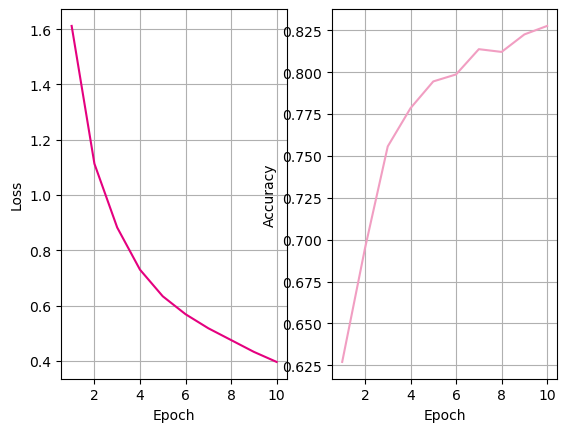

In [46]:
plt.subplot(1,2,1)
epochs = list(range(1,num_epochs+1))
plt.plot(epochs,loss_list , color='#e4007f', label="Train loss")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(epochs, accuracy_list, color='#f19ec2', label="test accuracy")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()